In [142]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout, GroupNormalization, ZeroPadding2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError as e:
    print("Error: ", e)
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Error:  Please provide a TPU Name to connect to.
Number of replicas: 1
2.17.0


In [4]:
def count_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [102]:
monet_filenames = tf.io.gfile.glob(str('./monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str('./photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(photo_filenames))

n_monet_samples = count_items(monet_filenames)
n_photo_samples = count_items(photo_filenames)

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [143]:
def decode_image(img):
    features = tf.io.parse_single_example(
        img,
        features={
            'image': tf.io.FixedLenFeature([], tf.string)
        }
    )
    image = features['image']
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def load_dataset(filenames):
    ds = tf.data.TFRecordDataset(filenames)
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)
    return ds

def get_gan_dataset(monet_files, photo_files, repeat=True, shuffle=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
        
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds = monet_ds.shuffle(2048)
        photo_ds = photo_ds.shuffle(2048)
        
    monet_ds = monet_ds.batch(batch_size, drop_remainder=True)
    photo_ds = photo_ds.batch(batch_size, drop_remainder=True)
    monet_ds = monet_ds.cache()
    photo_ds = photo_ds.cache()
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    
    gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))
    
    return gan_ds

In [109]:
monet_ds = load_dataset(monet_filenames).batch(1)
photo_ds = load_dataset(photo_filenames).batch(1)

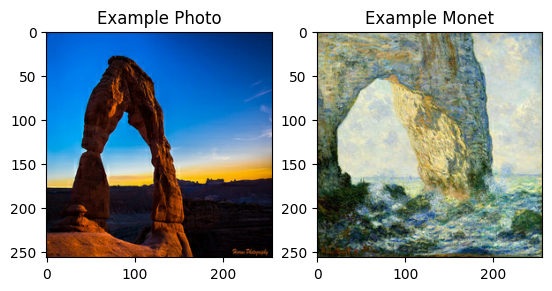

In [111]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(1,2,1)
plt.title('Example Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Example Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

In [133]:
def Generator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(32, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu'),
        GroupNormalization(groups=-1),
        Conv2DTranspose(64, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')
    ])
    return model

def Discriminator():
    model = Sequential([
        Input(shape=[256, 256, 3]),
        Conv2D(16, 4, strides=2, padding='same', activation='leaky_relu'),
        Conv2D(32, 4, strides=2, padding='same', activation='leaky_relu'),
        Dropout(0.2),
        ZeroPadding2D(),
        Conv2D(64, 4, strides=2, padding='same', activation='leaky_relu'),
        GroupNormalization(groups=-1),
        ZeroPadding2D(),
        Conv2D(1, 4, strides=1)
    ])
    return model

In [134]:
with strategy.scope():
    monet_generator = Generator()
    monet_discriminator = Discriminator()
    
    photo_generator = Generator()
    photo_discriminator = Discriminator()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


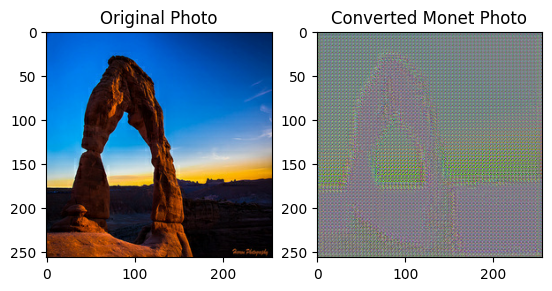

In [137]:
monet_gen_example = monet_generator.predict(example_photo)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Converted Monet Photo")
plt.imshow(monet_gen_example[0] * 0.5 + 0.5)
plt.show()

In [144]:
def discriminator_loss(real, generated):
    real_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_loss = real_loss + generated_loss
    return total_loss * 0.5

def generator_loss(generated):
    loss = BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    return loss

def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss
    
monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [145]:
class CycleGan(Model):
    def __init__(self,monet_generator,photo_generator,monet_discriminator,photo_discriminator,lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(self,monet_gen_optimizer,photo_gen_optimizer,monet_disc_optimizer,photo_disc_optimizer,
                generator_loss_fn,discriminator_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = monet_gen_optimizer
        self.p_gen_optimizer = photo_gen_optimizer
        self.m_disc_optimizer = monet_disc_optimizer
        self.p_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = generator_loss_fn
        self.disc_loss_fn = discriminator_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Photo->Monet->Photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Monet->Photo->Monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # Generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # Discriminator to check, inputting real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # Discriminator to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # Generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Total cycle loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Generator and discriminator gradients
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Applying gradients to optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [147]:
cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

cycle_gan_model.compile(
    monet_gen_optimizer = monet_generator_optimizer,
    photo_gen_optimizer = photo_generator_optimizer,
    monet_disc_optimizer = monet_discriminator_optimizer,
    photo_disc_optimizer = photo_discriminator_optimizer,
    generator_loss_fn = generator_loss,
    discriminator_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [150]:
history = cycle_gan_model.fit(
    get_gan_dataset(monet_filenames, photo_filenames, batch_size=32),
    steps_per_epoch=(max(n_monet_samples, n_photo_samples)//4),
    epochs=4
).history

Epoch 1/4
   6/1759 ━━━━━━━━━━━━━━━━━━━━ 1:54:07 4s/step - monet_disc_loss: 0.7625 - monet_gen_loss: 10.7587 - photo_disc_loss: 0.7682 - photo_gen_loss: 11.1111

KeyboardInterrupt: 